<h1>
    <center>
        A Hands-on Introduction to Geometric Deep Learning, with Examples in PyTorch Geometric - II
    </center>
</h1>

<h3>
    <center>
        SIAM-CSE, Amsterdam
    </center>
</h3>
<center>
    February 26 - March 3, 2023
   </center>

# input dataset

In [72]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


#%%
# We load graphs where the node feature x is defined by
# x = [position_x, position_y, parameter_1, ..., parameter_4, diameter]
# while y is the node target value.

#%% Loading path
path = './data/thermal_block/'


#%% Number of diameters and paramters
n_diam = 10
n_param = 5


#%% Load the graphs
G = {}

for idx_diam in range(n_diam):
    for idx_param in range(n_param):
        # Read the data
        edge_list = pd.read_csv(path + f'edge_list_diameter_{idx_diam}_param_{idx_param}.csv')        
        x = pd.read_csv(path + f'x_diameter_{idx_diam}_param_{idx_param}.csv')        
        y = pd.read_csv(path + f'y_diameter_{idx_diam}_param_{idx_param}.csv')        

        # Define the graph and assign the attributes
        G_tmp = nx.from_edgelist(edge_list.values)    
        nx.set_node_attributes(G_tmp, {idx: x.iloc[idx].values for idx in range(len(x))}, 'x')
        nx.set_node_attributes(G_tmp, {idx: y.iloc[idx].values for idx in range(len(y))}, 'y')
        
        G[(idx_diam, idx_param)] = G_tmp 

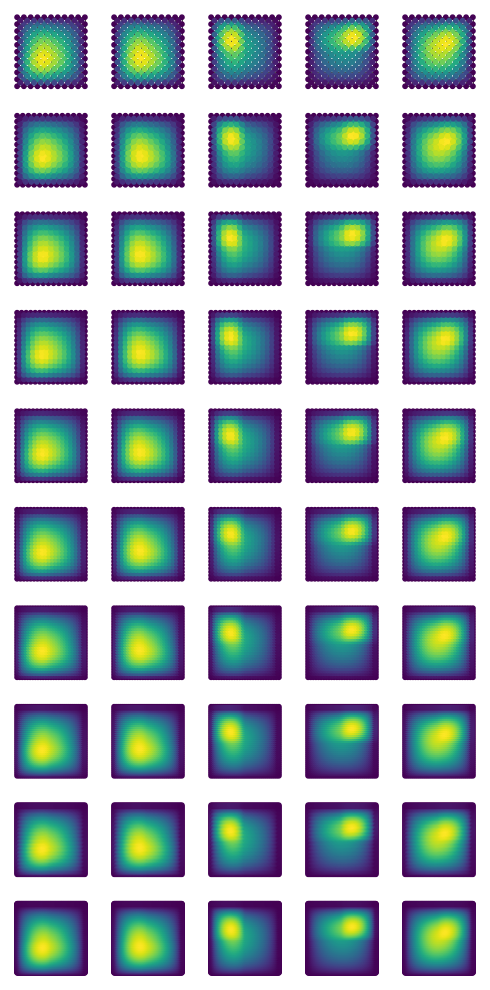

In [82]:
#%% Plot the graphs with node coloring corresponding to y
fig = plt.figure(0, figsize=(n_param, n_diam))
fig.clf()

N = n_param * n_diam

for idx_diam in range(n_diam):
    for idx_param in range(n_param):
        graph = G[(idx_diam, idx_param)]
        x = nx.get_node_attributes(graph, 'x')
        y = nx.get_node_attributes(graph, 'y')
        pos = {idx: x[idx][:2] for idx in x}
        y = np.array([y[idx] for idx in y])
        
        ax = fig.add_subplot(n_diam, n_param, 1 + idx_param + idx_diam * n_param)
        nx.draw(graph, pos=pos, 
                node_size=10, 
                width=0.5,
                node_color=y,
                ax=ax)
    
fig.tight_layout()

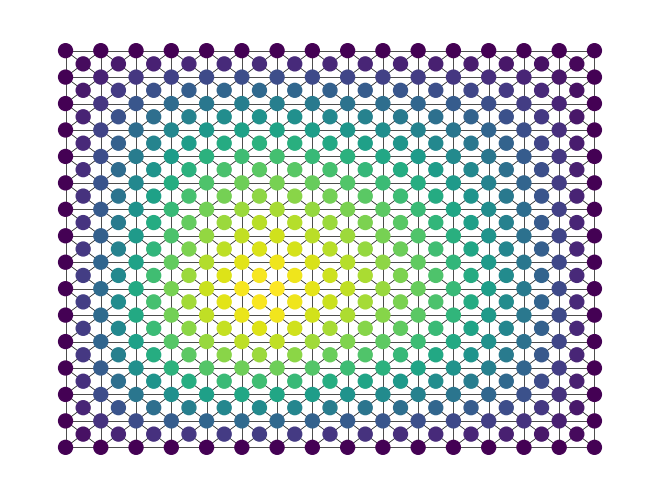

In [84]:
g = G[(3,0)]
x = nx.get_node_attributes(g, 'x')
y = nx.get_node_attributes(g, 'y')
pos = {idx: x[idx][:2] for idx in x}
y = [y[idx] for idx in y]

nx.draw(g, pos=pos, 
        node_size=100, 
        width=0.5,
        node_color=y)

# Load the graph


In [32]:
import torch
from typing import Optional, Callable
from torch_geometric.data import InMemoryDataset,Data
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import to_undirected

import pandas as pd
import networkx as nx
import numpy as np

In [33]:
class GraphReading(InMemoryDataset):  
    def __init__(self,
                 transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None,
                 pre_filter: Optional[Callable] = None,):
        
        super().__init__('.', transform, pre_transform, pre_filter)
        

        
        path = './data/thermal_block/'
        #%% Number of diameters and paramters
        n_diam = 10
        n_param = 1 # 5
        
        data_list = []
        
        #%% Load the graphs
        for idx_diam in range(n_diam):
            for idx_param in range(n_param):
                # Read the data
                edge_list = pd.read_csv(path + f'edge_list_diameter_{idx_diam}_param_{idx_param}.csv')        
                x = pd.read_csv(path + f'x_diameter_{idx_diam}_param_{idx_param}.csv')        
                y = pd.read_csv(path + f'y_diameter_{idx_diam}_param_{idx_param}.csv')        

                y = (y)/(y.max())
                # Define the graph and assign the attributes
                G_tmp = nx.from_edgelist(edge_list.values)    

                nx.set_node_attributes(G_tmp, {idx: x.iloc[idx].values for idx in range(len(x))}, 'x')
                nx.set_node_attributes(G_tmp, {idx: y.iloc[idx].values for idx in range(len(y))}, 'y')


                # Build the data object
                edge_index = torch.tensor([[i,j] for i,j in (G_tmp.edges())]).T
                edge_index = to_undirected(edge_index)
                x = torch.tensor(np.array(list(nx.get_node_attributes(G_tmp,"x").values())))
                y = torch.tensor(np.array(list(nx.get_node_attributes(G_tmp,"y").values())))

                data = Data(x=x, edge_index=edge_index, y=y)
                data_list.append(data)


        self.data, self.slices = self.collate(data_list)

In [34]:
dataset = GraphReading(transform=NormalizeFeatures())
dataset

GraphReading(10)

In [35]:
dataset[0]

Data(x=[221, 7], edge_index=[2, 1240], y=[221, 1])

In [36]:
dataset[0].x[10]

tensor([0.1803, 0.0000, 0.1037, 0.1924, 0.1726, 0.3149, 0.0361],
       dtype=torch.float64)

In [37]:
dataset[0].x.numpy()

array([[0.        , 0.04214296, 0.12120926, ..., 0.20164743, 0.36801923,
        0.04214296],
       [0.        , 0.        , 0.12654212, ..., 0.21051933, 0.38421102,
        0.04399713],
       [0.04214296, 0.        , 0.12120926, ..., 0.20164743, 0.36801923,
        0.04214296],
       ...,
       [0.18878014, 0.23912151, 0.07239454, ..., 0.12043776, 0.21980649,
        0.02517069],
       [0.20869776, 0.23325044, 0.07061706, ..., 0.11748069, 0.21440965,
        0.02455268],
       [0.22766076, 0.22766076, 0.06892477, ..., 0.11466535, 0.20927147,
        0.02396429]])

In [38]:
from torch_geometric.utils import is_undirected,to_undirected

is_undirected(dataset[0].edge_index)

True

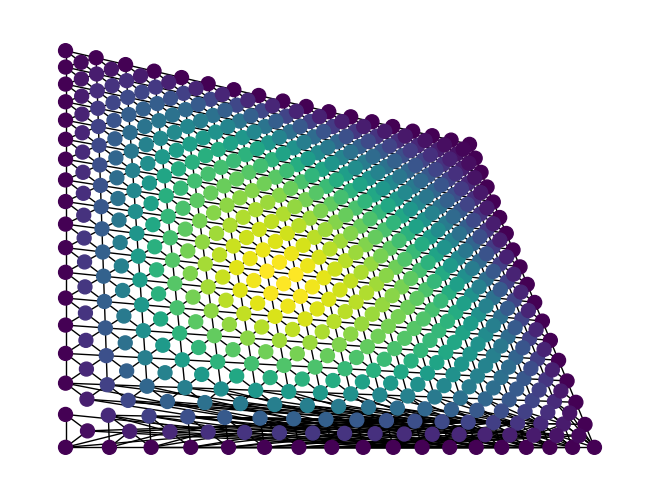

In [81]:
# to networkx
from torch_geometric.utils import to_networkx

# convert to networkx
g = to_networkx(dataset[4],node_attrs=["x","y"],to_undirected=True)
# get x and y
x = nx.get_node_attributes(g,"x")
y = nx.get_node_attributes(g, 'y')

# draw the graph
pos = {idx: x[idx][:2] for idx in x}
color = np.array([y[idx] for idx in y])

nx.draw(g, pos=pos, 
        node_size=100,
        node_color=color)

# test train split

In [40]:
from sklearn.model_selection import train_test_split

idx_train,idx_test = train_test_split(range(len(dataset)),test_size=0.1,random_state=10)

train_dataset = dataset[idx_train]
test_dataset = dataset[idx_test]

print("Train set length: \t",len(train_dataset))
print("Test set length: \t",len(test_dataset))

Train set length: 	 9
Test set length: 	 1


In [41]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset,batch_size=7)
test_loader = DataLoader(test_dataset,batch_size=7)

In [42]:
for data in train_loader:
    print(data)

DataBatch(x=[6007, 7], edge_index=[2, 34960], y=[6007, 1], batch=[6007], ptr=[8])
DataBatch(x=[20814, 7], edge_index=[2, 123936], y=[20814, 1], batch=[20814], ptr=[3])


In [43]:
for data in test_loader:
    print(data)

DataBatch(x=[5305, 7], edge_index=[2, 31416], y=[5305, 1], batch=[5305], ptr=[2])


### Batch training
![alt text](miniBatch.png "Title")

In [44]:
train_loader = DataLoader(train_dataset,batch_size=1)
test_loader = DataLoader(test_dataset,batch_size=1)

In [45]:
# define the model 
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        
        self.conv1 = GCNConv(in_channels, hidden_channels)              # 7 -> 20
        self.conv2 = GCNConv(hidden_channels, int((hidden_channels)/5)) # 20 -> 4
        self.conv3 = GCNConv(int((hidden_channels)/5), out_channels)    # 4 -> 1

    def forward(self, x, edge_index):
        
        x = self.conv1(x, edge_index).relu() # relu activation function
        x = self.conv2(x, edge_index).relu() # relu activation function
        x = self.conv3(x, edge_index)
        
        return x

In [46]:
# do we have cuda?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# instanziate the model
model = GCN(dataset.num_features, 20, 1).double().to(device)
# instanziate the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

model

GCN(
  (conv1): GCNConv(7, 20)
  (conv2): GCNConv(20, 4)
  (conv3): GCNConv(4, 1)
)

In [47]:
model.conv1

GCNConv(7, 20)

In [48]:
model.conv1.lin.weight

Parameter containing:
tensor([[ 0.0424,  0.2655,  0.1204,  0.4042, -0.1507, -0.3324,  0.3595],
        [-0.2707,  0.1418, -0.2885, -0.0553, -0.1566, -0.1359,  0.3715],
        [-0.0956, -0.3411,  0.3177, -0.0842,  0.3374, -0.4109,  0.0656],
        [-0.3589,  0.3575, -0.3997, -0.3697, -0.1212,  0.2888, -0.2608],
        [-0.3142, -0.4281,  0.3755, -0.0889, -0.1901, -0.1521, -0.1155],
        [ 0.4458, -0.3852,  0.4202, -0.1924,  0.2630,  0.0581,  0.3926],
        [ 0.1598, -0.1020,  0.4199,  0.1574, -0.3541,  0.2271, -0.4273],
        [ 0.3448, -0.0952,  0.2370,  0.0866,  0.0700,  0.1622,  0.0527],
        [ 0.1250, -0.3334,  0.3562, -0.1823,  0.1181, -0.4027, -0.0050],
        [ 0.0373,  0.3792, -0.1756,  0.1431, -0.2896, -0.0374,  0.3615],
        [ 0.4459, -0.3525,  0.1405,  0.0409,  0.1917,  0.1836, -0.0682],
        [ 0.1566,  0.4509,  0.2724, -0.4377, -0.1140, -0.3004, -0.4186],
        [ 0.3676,  0.3727,  0.4516, -0.0830, -0.1110, -0.0011, -0.0482],
        [-0.3432, -0.3534, -0

In [49]:
import torch.nn.functional as F
def train(train_loader):
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x.double(), data.edge_index)
        loss = F.mse_loss(out,data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss)
    return total_loss/ len(train_loader.dataset)


@torch.no_grad()
def test(loader):
    model.eval()

    tot_loss = 0
    for data in loader:
        data = data.to(device)
        pred = model(data.x.double(), data.edge_index)
        loss = F.mse_loss(pred,data.y)
        tot_loss += float(loss)

    return tot_loss/ len(loader.dataset)
    

In [50]:
for epoch in range(1, 100 + 1):
    loss = train(train_loader)
    test_loss = test(test_loader)
    if epoch % 10 == 0:
        print("Epoch:",epoch,'\tTrain loss: %.4f' % loss,'\tTest loss: %.4f' % test_loss)

Epoch: 10 	Train loss: 0.0879 	Test loss: 0.0834
Epoch: 20 	Train loss: 0.0846 	Test loss: 0.0801
Epoch: 30 	Train loss: 0.0802 	Test loss: 0.0754
Epoch: 40 	Train loss: 0.0736 	Test loss: 0.0685
Epoch: 50 	Train loss: 0.0643 	Test loss: 0.0586
Epoch: 60 	Train loss: 0.0505 	Test loss: 0.0437
Epoch: 70 	Train loss: 0.0327 	Test loss: 0.0260
Epoch: 80 	Train loss: 0.0199 	Test loss: 0.0140
Epoch: 90 	Train loss: 0.0127 	Test loss: 0.0083
Epoch: 100 	Train loss: 0.0103 	Test loss: 0.0067


In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def my_plot(train_loader,test_loader,device):
    
    pred_train, pred_test = [], []
    y_train, y_test = [], []
    
    for data in train_loader:
        data = data.to(device)
        pred_train.extend(model(data.x,data.edge_index).detach().cpu().numpy().reshape(-1))
        y_train.extend(data.y.detach().cpu().numpy().reshape(-1))
        
    for data in test_loader:
        data = data.to(device)
        pred_test.extend(model(data.x,data.edge_index).detach().cpu().numpy().reshape(-1))
        y_test.extend(data.y.detach().cpu().numpy().reshape(-1))  
        
    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(8,4))
    ax1.set_title("Train\n r2 score: %.3f " % r2_score(pred_train,y_train))
    ax1.set_xlabel("Prediction")
    ax1.set_ylabel("Real")
    ax1.scatter(pred_train,y_train,alpha=0.002,color="blue")
    ax1.plot([0,1],"-.",color="red")

    ax2.set_title("Test\n r2 score: %.3f " % r2_score(pred_test,y_test))
    ax2.set_xlabel("Prediction")
    ax2.set_ylabel("Real")
    ax2.scatter(pred_test,y_test,alpha=0.002,color="blue")
    ax2.plot([0,1],"-.",color="red",)
    plt.show()
                   

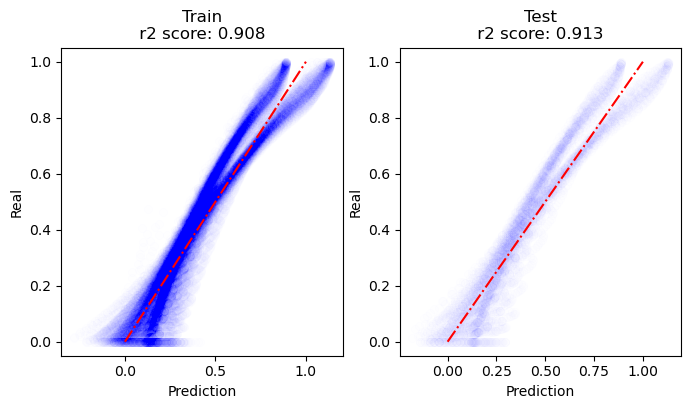

In [52]:
my_plot(train_loader,test_loader,device)

# SAGE

In [53]:
from torch_geometric.nn import SAGEConv
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        

        self.conv1 = SAGEConv(in_channels,hidden_channels)
        self.conv2 = SAGEConv(hidden_channels,hidden_channels)
        self.conv3 = SAGEConv(hidden_channels,out_channels)
        


    def forward(self, x, edge_index):
        
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x,edge_index)
        return x

    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GIN(dataset.num_features, 10, 1).double().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

model

GIN(
  (conv1): SAGEConv(7, 10, aggr=mean)
  (conv2): SAGEConv(10, 10, aggr=mean)
  (conv3): SAGEConv(10, 1, aggr=mean)
)

In [54]:
for epoch in range(1, 100 + 1):
    loss = train(train_loader)
    test_loss = test(test_loader)
    if epoch % 10 == 0:
        print("Epoch:",epoch,'\tTrain loss: %.4f' % loss,'\tTest loss: %.4f' % test_loss)

Epoch: 10 	Train loss: 0.2955 	Test loss: 0.2931
Epoch: 20 	Train loss: 0.0832 	Test loss: 0.0781
Epoch: 30 	Train loss: 0.0720 	Test loss: 0.0660
Epoch: 40 	Train loss: 0.0570 	Test loss: 0.0506
Epoch: 50 	Train loss: 0.0465 	Test loss: 0.0401
Epoch: 60 	Train loss: 0.0322 	Test loss: 0.0259
Epoch: 70 	Train loss: 0.0095 	Test loss: 0.0053
Epoch: 80 	Train loss: 0.0053 	Test loss: 0.0031
Epoch: 90 	Train loss: 0.0045 	Test loss: 0.0026
Epoch: 100 	Train loss: 0.0041 	Test loss: 0.0023


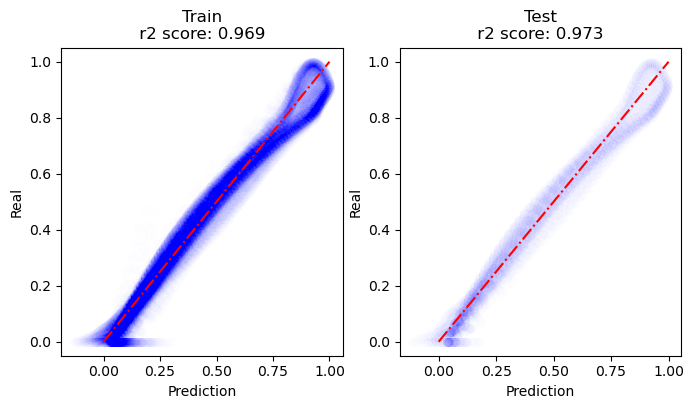

In [55]:
my_plot(train_loader,test_loader,device)

# GAT

In [56]:
from torch_geometric.nn import GATConv

class GAT_model(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        
        self.conv1 = GATConv(in_channels,hidden_channels,heads=2)
        self.conv2 = GATConv(hidden_channels*2,hidden_channels,heads=2)
        self.conv3 = GATConv(hidden_channels*2,out_channels,heads=1)


    def forward(self, x, edge_index):
        
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x,edge_index)
        return x

    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT_model(dataset.num_features, 10, 1).double().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

model

GAT_model(
  (conv1): GATConv(7, 10, heads=2)
  (conv2): GATConv(20, 10, heads=2)
  (conv3): GATConv(20, 1, heads=1)
)

In [57]:
for epoch in range(1, 100 + 1):
    loss = train(train_loader)
    test_loss = test(test_loader)
    if epoch % 10 == 0:
        print("Epoch:",epoch,'\tTrain loss: %.4f' % loss,'\tTest loss: %.4f' % test_loss)

Epoch: 10 	Train loss: 0.0856 	Test loss: 0.0808
Epoch: 20 	Train loss: 0.0788 	Test loss: 0.0737
Epoch: 30 	Train loss: 0.0679 	Test loss: 0.0619
Epoch: 40 	Train loss: 0.0523 	Test loss: 0.0455
Epoch: 50 	Train loss: 0.0322 	Test loss: 0.0248
Epoch: 60 	Train loss: 0.0168 	Test loss: 0.0105
Epoch: 70 	Train loss: 0.0106 	Test loss: 0.0060
Epoch: 80 	Train loss: 0.0086 	Test loss: 0.0047
Epoch: 90 	Train loss: 0.0077 	Test loss: 0.0042
Epoch: 100 	Train loss: 0.0071 	Test loss: 0.0038


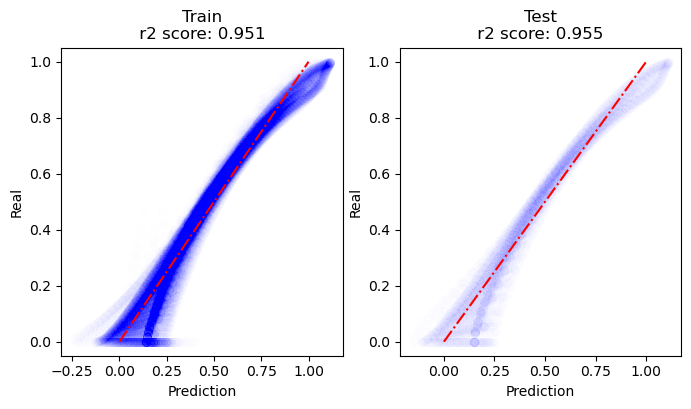

In [58]:
my_plot(train_loader,test_loader,device)

# Cheb

In [59]:
from torch_geometric.nn import ChebConv

class Cheb(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        
        self.conv1 = ChebConv(in_channels,hidden_channels,K=3)
        self.conv2 = ChebConv(hidden_channels,hidden_channels,K=3)
        self.conv3 = ChebConv(hidden_channels,out_channels,K=3)


    def forward(self, x, edge_index):
        
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x,edge_index)
        return x

    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Cheb(dataset.num_features, 10, 1).double().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

model

Cheb(
  (conv1): ChebConv(7, 10, K=3, normalization=sym)
  (conv2): ChebConv(10, 10, K=3, normalization=sym)
  (conv3): ChebConv(10, 1, K=3, normalization=sym)
)

In [60]:
for epoch in range(1, 100 + 1):
    loss = train(train_loader)
    test_loss = test(test_loader)
    if epoch % 10 == 0:
        print("Epoch:",epoch,'\tTrain loss: %.4f' % loss,'\tTest loss: %.4f' % test_loss)

Epoch: 10 	Train loss: 0.0821 	Test loss: 0.0730
Epoch: 20 	Train loss: 0.0510 	Test loss: 0.0412
Epoch: 30 	Train loss: 0.0264 	Test loss: 0.0188
Epoch: 40 	Train loss: 0.0176 	Test loss: 0.0122
Epoch: 50 	Train loss: 0.0142 	Test loss: 0.0099
Epoch: 60 	Train loss: 0.0122 	Test loss: 0.0087
Epoch: 70 	Train loss: 0.0112 	Test loss: 0.0080
Epoch: 80 	Train loss: 0.0103 	Test loss: 0.0073
Epoch: 90 	Train loss: 0.0095 	Test loss: 0.0067
Epoch: 100 	Train loss: 0.0087 	Test loss: 0.0062


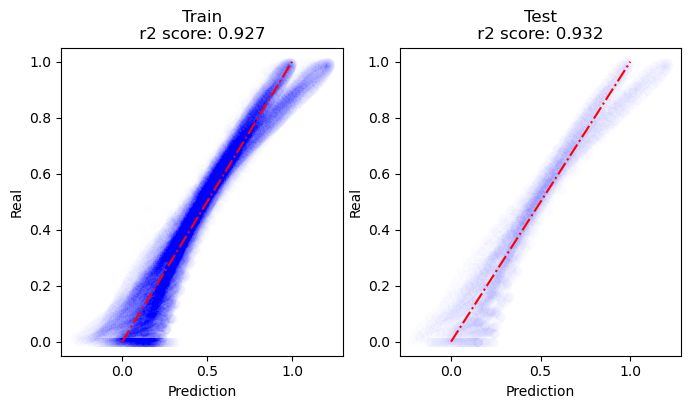

In [61]:
my_plot(train_loader,test_loader,device)

# GIN

In [62]:
from torch_geometric.nn import MLP,GINConv
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        
        mlp = MLP([in_channels, 20, 20])
        self.conv1 = GINConv(nn=mlp, train_eps=False)
        
        self.bn1 = torch.nn.BatchNorm1d(20)

        mlp = MLP([20, 30, 10])
        self.conv2 = GINConv(nn=mlp)
        self.bn2 = torch.nn.BatchNorm1d(10)

        mlp = MLP([10, 5, out_channels])
        self.conv3 = GINConv(nn=mlp)
        


    def forward(self, x, edge_index):
        
        x = self.conv1(x, edge_index).relu()
        x = self.bn1(x)
        x = self.conv2(x, edge_index).relu()
        x = self.bn2(x)
        x = self.conv3(x,edge_index)
        return x

    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GIN(dataset.num_features, 10, 1).double().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

model

GIN(
  (conv1): GINConv(nn=MLP(7, 20, 20))
  (bn1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GINConv(nn=MLP(20, 30, 10))
  (bn2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GINConv(nn=MLP(10, 5, 1))
)

In [63]:
for epoch in range(1, 100 + 1):
    loss = train(train_loader)
    test_loss = test(test_loader)
    if epoch % 10 == 0:
        print("Epoch:",epoch,'\tTrain loss: %.4f' % loss,'\tTest loss: %.4f' % test_loss)

Epoch: 10 	Train loss: 0.2417 	Test loss: 0.2249
Epoch: 20 	Train loss: 0.0512 	Test loss: 0.0420
Epoch: 30 	Train loss: 0.0126 	Test loss: 0.0129
Epoch: 40 	Train loss: 0.0048 	Test loss: 0.0075
Epoch: 50 	Train loss: 0.0034 	Test loss: 0.0071
Epoch: 60 	Train loss: 0.0029 	Test loss: 0.0067
Epoch: 70 	Train loss: 0.0026 	Test loss: 0.0062
Epoch: 80 	Train loss: 0.0024 	Test loss: 0.0059
Epoch: 90 	Train loss: 0.0023 	Test loss: 0.0054
Epoch: 100 	Train loss: 0.0022 	Test loss: 0.0050


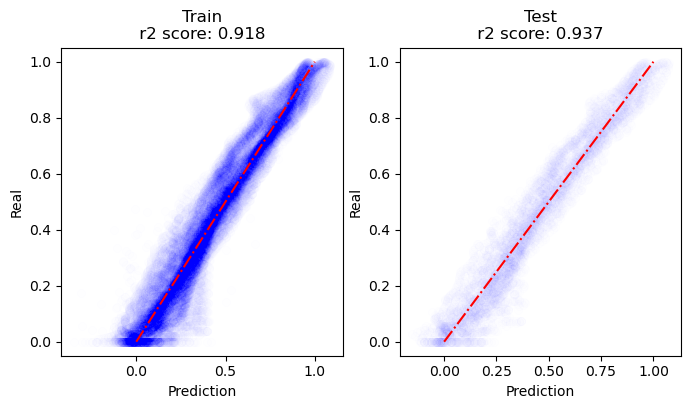

In [64]:
my_plot(train_loader,test_loader,device)

# it seems difficult to compare models

In [65]:
from torch_geometric.loader import DataLoader

import torch.nn.functional as F
def train(train_loader):
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x.double(), data.edge_index)
        loss = F.mse_loss(out,data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss)
    return total_loss/ len(train_loader.dataset)


@torch.no_grad()
def test(loader):
    model.eval()

    tot_loss = 0
    for data in loader:
        data = data.to(device)
        pred = model(data.x.double(), data.edge_index)
        loss = F.mse_loss(pred,data.y)
        tot_loss += float(loss)

    return tot_loss/ len(loader.dataset)
    

In [66]:
class GraphReading(InMemoryDataset):  
    def __init__(self,
                 transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None,
                 pre_filter: Optional[Callable] = None,):
        
        super().__init__('.', transform, pre_transform, pre_filter)
        

        
        path = './data/thermal_block/'
        #%% Number of diameters and paramters
        n_diam = 10
        n_param = 1
        
        data_list = []
        
        #%% Load the graphs
        for idx_diam in range(n_diam):
            for idx_param in range(n_param):
                # Read the data
                edge_list = pd.read_csv(path + f'edge_list_diameter_{idx_diam}_param_{idx_param}.csv')        
                x = pd.read_csv(path + f'x_diameter_{idx_diam}_param_{idx_param}.csv')        
                y = pd.read_csv(path + f'y_diameter_{idx_diam}_param_{idx_param}.csv')        

                y = (y)/(y.max())
                # Define the graph and assign the attributes
                G_tmp = nx.from_edgelist(edge_list.values)    

                nx.set_node_attributes(G_tmp, {idx: x.iloc[idx].values for idx in range(len(x))}, 'x')
                nx.set_node_attributes(G_tmp, {idx: y.iloc[idx].values for idx in range(len(y))}, 'y')


                # Build the data object
                edge_index = torch.tensor([[i,j] for i,j in (G_tmp.edges())]).T
                edge_index = to_undirected(edge_index)
                x = torch.tensor(np.array(list(nx.get_node_attributes(G_tmp,"x").values())))
                y = torch.tensor(np.array(list(nx.get_node_attributes(G_tmp,"y").values())))

                data = Data(x=x, edge_index=edge_index, y=y)
                data_list.append(data)


        self.data, self.slices = self.collate(data_list)

In [67]:
dataset = GraphReading(transform=NormalizeFeatures())
dataset

GraphReading(10)

In [68]:
from sklearn.model_selection import train_test_split

idx_train,idx_test = train_test_split(range(len(dataset)),test_size=0.1,random_state=10)

train_dataset = dataset[idx_train]
test_dataset = dataset[idx_test]

print("Train set length: \t",len(train_dataset))
print("Test set length: \t",len(test_dataset))

Train set length: 	 9
Test set length: 	 1


In [69]:
train_loader = DataLoader(train_dataset,batch_size=1)
test_loader = DataLoader(test_dataset,batch_size=1)

In [70]:
# define the model 
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        
        self.conv1 = GCNConv(in_channels, hidden_channels)              # 7 -> 20
        self.conv2 = GCNConv(hidden_channels, int((hidden_channels)/5)) # 20 -> 4
        self.conv3 = GCNConv(int((hidden_channels)/5), out_channels)    # 4 -> 1

    def forward(self, x, edge_index):
        
        x = self.conv1(x, edge_index).relu() # relu activation function
        x = self.conv2(x, edge_index).relu() # relu activation function
        x = self.conv3(x, edge_index)
        
        return x
# do we have cuda?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

# instanziate the model
model = GCN(dataset.num_features, 50, 1).double().to(device)
# instanziate the optimizer
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

model

GCN(
  (conv1): GCNConv(7, 50)
  (conv2): GCNConv(50, 10)
  (conv3): GCNConv(10, 1)
)

In [71]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir="runs/lr_"+str(lr)+"version4")

writer.add_graph(model, [dataset.data.x.to(device), dataset.data.edge_index.to(device)])


for epoch in range(1, 1000 + 1):
    loss = train(train_loader)
    test_loss = test(test_loader)
    if epoch % 10 == 0:
        print("Epoch:",epoch,'\tTrain loss: %.4f' % loss,'\tTest loss: %.4f' % test_loss)

    writer.add_scalar('Loss/train', loss, epoch)
    writer.add_scalar('Loss/test', test_loss, epoch)


Epoch: 10 	Train loss: 0.0884 	Test loss: 0.0841
Epoch: 20 	Train loss: 0.0831 	Test loss: 0.0781
Epoch: 30 	Train loss: 0.0714 	Test loss: 0.0651
Epoch: 40 	Train loss: 0.0519 	Test loss: 0.0444
Epoch: 50 	Train loss: 0.0274 	Test loss: 0.0204
Epoch: 60 	Train loss: 0.0152 	Test loss: 0.0102
Epoch: 70 	Train loss: 0.0112 	Test loss: 0.0072
Epoch: 80 	Train loss: 0.0095 	Test loss: 0.0061
Epoch: 90 	Train loss: 0.0086 	Test loss: 0.0055
Epoch: 100 	Train loss: 0.0080 	Test loss: 0.0051
Epoch: 110 	Train loss: 0.0075 	Test loss: 0.0047
Epoch: 120 	Train loss: 0.0071 	Test loss: 0.0044
Epoch: 130 	Train loss: 0.0068 	Test loss: 0.0041
Epoch: 140 	Train loss: 0.0065 	Test loss: 0.0039
Epoch: 150 	Train loss: 0.0063 	Test loss: 0.0037
Epoch: 160 	Train loss: 0.0061 	Test loss: 0.0036
Epoch: 170 	Train loss: 0.0059 	Test loss: 0.0034
Epoch: 180 	Train loss: 0.0058 	Test loss: 0.0033
Epoch: 190 	Train loss: 0.0057 	Test loss: 0.0033
Epoch: 200 	Train loss: 0.0056 	Test loss: 0.0032
Epoch: 21

In [ ]:
# command line
# tensorboard --logdir logs/fit